In [36]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle as pkl
from scipy.signal import savgol_filter

In [15]:
PHOTROOT = "/mnt/Astronomy/GraduateSchool/Thesis/GCConsistency/NGC2808/photometry/HUGS/ngc2808/photometry.pkl"

In [16]:
densityCache = "/mnt/Astronomy/packages/localTests/fidanka/MC_1_Density.npz"
assert os.path.exists(densityCache), "Density Cache File not Found!" 

In [115]:
def binDensityKeepingCountingStatisticsTheSame(color, mag, density, targetStat=1000):
    srtedIDX = np.argsort(mag)
    sMag = mag[srtedIDX]
    sColor = color[srtedIDX]
    sDensity = density[srtedIDX]
    subs = np.floor(sMag.shape[0]/targetStat).astype(int)
    binsM = np.array_split(sMag, subs)
    binsC = np.array_split(sColor, subs)
    binsD = np.array_split(sDensity, subs)
    
    return binsC, binsM, binsD

In [116]:
def detect_peaks(data, min_peak_height=0.5, min_peak_distance=1):
    peaks, _ = find_peaks(data)
    return peaks

def align_peaks(peaks):
    # Instead of trying to align all peaks at once, we'll process them one dataset at a time
    aligned_peaks = []
    for peak_set in peaks:
        # Compute the pairwise distances between the current peak set and the first one
        distances = pdist(np.vstack([peaks[0], peak_set]))
        # Convert the pairwise distances to a square distance matrix
        dist_matrix = squareform(distances)
        # Get the minimum distance and its index for each peak in the current set
        min_distances = np.min(dist_matrix[peak_set.size:], axis=0)
        min_indices = np.argmin(dist_matrix[peak_set.size:], axis=0)
        # Use these indices to align the current peak set with the first one
        aligned_peak_set = peak_set[min_indices]
        aligned_peaks.append(aligned_peak_set)
    return aligned_peaks

In [140]:
def track_peaks(density, color, magnitude):
    n_datasets, n_points = density.shape
    
    # Initialize a list to store the peaks for each dataset
    all_peaks = []
    
    # Initialize a Kalman filter for each point in the dataset
    filters = [KalmanFilter(dim_x=2, dim_z=1) for _ in range(n_points)]
    
    # Initialize the filters
    for f in filters:
        f.x = np.array([[0.], [0.]])  # initial state (peak position and velocity)
        f.F = np.array([[1.,1.], [0.,1.]])  # state transition matrix
        f.H = np.array([[1., 0.]])  # measurement function
        f.P *= 1000.  # covariance matrix
        f.R = np.array([[5.]])  # measurement uncertainty
        f.Q = np.eye(2) * 0.1  # process noise
    
    # Initialize the list of peak positions in the previous dataset
    prev_peak_colors = None
    
    # Now we iterate over the datasets
    for i in range(n_datasets):
        # We find the peaks in the current dataset
        peaks, _ = find_peaks(density[i, :], prominence=1)
        peak_colors = color[i, peaks]
        
        # If this is not the first dataset, we use the Kalman filters to predict the peak positions
        if prev_peak_colors is not None:
            # We estimate the peak position for each point in the dataset using the corresponding Kalman filter
            estimated_peak_colors = np.empty_like(prev_peak_colors)
            estimated_peak_magnitudes = np.empty_like(prev_peak_colors)
            for j, prev_peak_color in enumerate(prev_peak_colors):
                f = filters[j]
                f.predict()
                # We find the peak closest to the predicted position
                closest_peak_index = np.argmin(np.abs(peak_colors - f.x[0, 0]))
                f.update(np.array([[peak_colors[closest_peak_index]]]))
                estimated_peak_colors[j] = f.x[0, 0]
                estimated_peak_magnitudes[j] = np.mean(magnitude[i, peaks[closest_peak_index]])
        else:
            # In the first dataset, we just use the observed peak positions
            estimated_peak_colors = peak_colors
            estimated_peak_magnitudes = np.mean(magnitude[i, :], axis=1)
        
        all_peaks.append(np.column_stack([estimated_peak_colors, estimated_peak_magnitudes]))
        
        # We update the list of peak positions for the next iteration
        prev_peak_colors = estimated_peak_colors
    
    return all_peaks


In [141]:
def process_dataset(color, mag, density, windowSize = 50, polyOrder=2):
    tracked_peaks = track_peaks(color, mag, density)

    return tracked_peaks

In [119]:
density = np.load(densityCache)['density']
with open(PHOTROOT, 'rb') as f:
    HUGSPhotometry = pkl.load(f)[1]
color = HUGSPhotometry["F275W"] - HUGSPhotometry["F814W"]
mag = HUGSPhotometry["F814"]
HUGSPhotometry['density'] = density

colorBins, magBins, densityBins = binDensityKeepingCountingStatisticsTheSame(color.values, mag.values, density)

In [120]:
o = process_dataset(colorBins, magBins, densityBins)

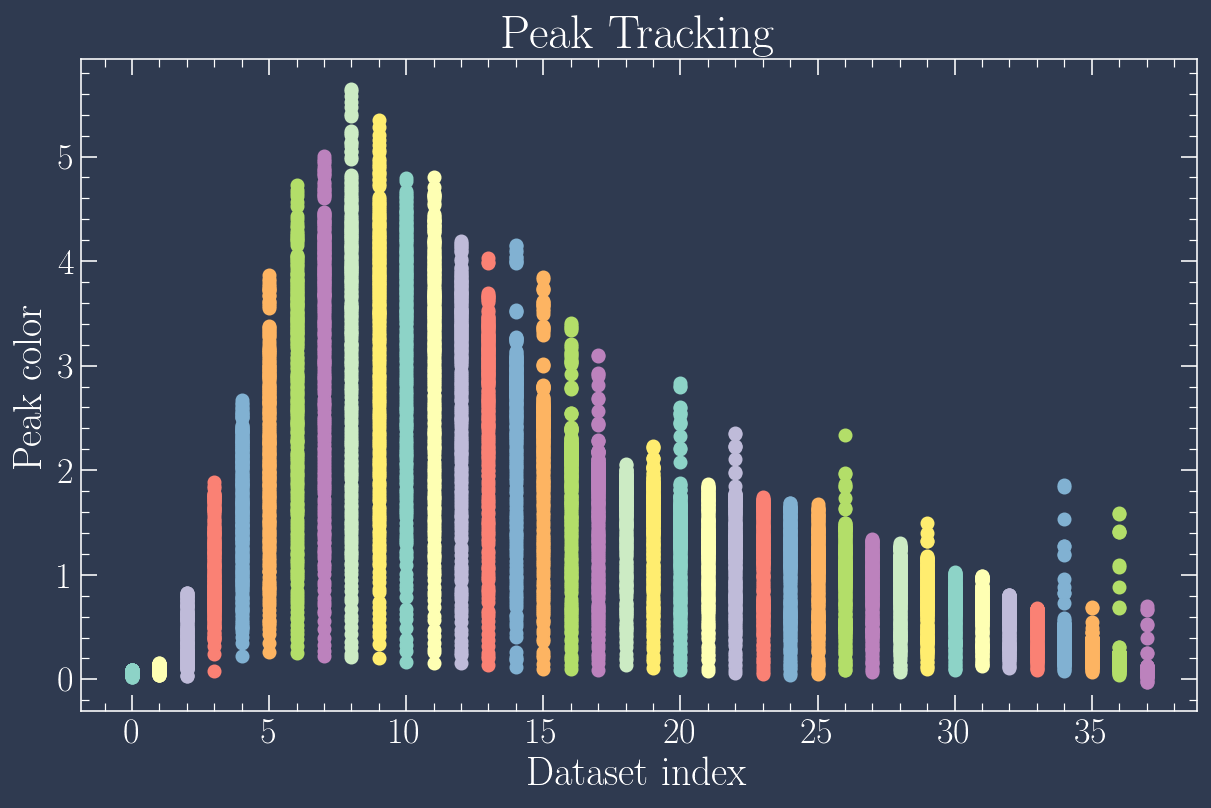

In [138]:
import matplotlib.pyplot as plt
# Assume peak_colors is the result from track_peaks function
def plot_peak_tracking(peak_colors):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot the estimated peak colors for each dataset
    for i, colors in enumerate(peak_colors):
        plt.plot([i] * len(colors), colors, 'o')

    # Set the plot title and labels
    plt.title('Peak Tracking')
    plt.xlabel('Dataset index')
    plt.ylabel('Peak color')

    # Show the plot
    plt.show()
plot_peak_tracking(o)

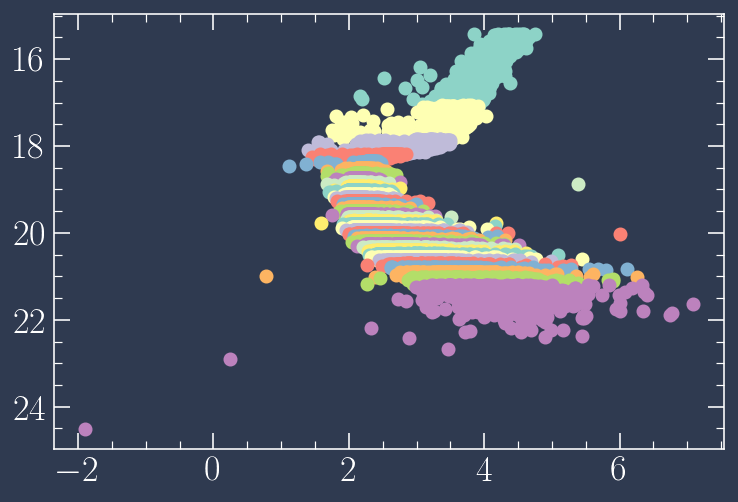

In [137]:
for color, mag in zip(colorBins, magBins):
    plt.scatter(color, mag)
plt.gca().invert_yaxis()